# Image classifier project

## Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Import modules

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils

## Configure torch device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configure the locations of the source data

In [5]:
data_dir = 'flowers'
training_data_dir = data_dir + '/train'
validation_data_dir = data_dir + '/valid'
testing_data_dir = data_dir + '/test'

## Define transforms, datasets and dataloaders

In [6]:
# Define transforms for the training, validation, and testing sets
normalised_transform = transforms.Normalize([0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])

training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          normalised_transform])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            normalised_transform])

testing_transforms = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            normalised_transform])

# Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(training_data_dir, 
                                        transform=training_transforms)
validation_dataset = datasets.ImageFolder(validation_data_dir, 
                                          transform=validation_transforms)
testing_dataset = datasets.ImageFolder(testing_data_dir, 
                                       transform=testing_transforms)

# Define the dataloaders using the image datasets and trainforms
training_dataloader = torch.utils.data.DataLoader(training_dataset, 
                                                  batch_size=64, 
                                                  shuffle=True,
                                                  pin_memory=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    pin_memory=True)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset,
                                                 batch_size=64,
                                                 shuffle=True,
                                                 pin_memory=True)

In [7]:
import json

with open('cat_to_name.json', 'r') as file:
    cat_to_name = json.load(file)

len(cat_to_name)

102

## Define the model

In [8]:
def create_model_densenet121(hidden_size=256, lr=0.003):
    model = models.densenet121(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = nn.Sequential(nn.Linear(1024, hidden_size),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(hidden_size, 102),
                                     nn.LogSoftmax(dim=1))

    criterion = nn.NLLLoss()

    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr)

    return model, optimizer, criterion

In [86]:
def create_model_densenet121_1():
    model = models.densenet121(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256, 102),
                                    nn.LogSoftmax(dim=1))

    criterion = nn.NLLLoss()

    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

    return model, optimizer, criterion

In [87]:
def create_model_resnet101():
    model = models.resnet101(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Sequential(nn.Linear(2048, 256),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(256, 102),
                             nn.LogSoftmax(dim=1))

    criterion = nn.NLLLoss()

    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

    return model, optimizer, criterion

In [88]:
def create_model_vgg11():
    model = models.vgg11(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier[-1] = nn.Sequential(nn.Linear(4096, 256),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(256, 102),
                                        nn.LogSoftmax(dim=1))

    criterion = nn.NLLLoss()

    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

    return model, optimizer, criterion

## Train the model

In [92]:
epochs = 15
steps = 0

hidden_size = 256
lr = 0.0005
model, optimizer, criterion = create_model_densenet121(hidden_size, lr)
model.to(device)

training_losses, validation_losses = [], []
for e in range(epochs):

    start_time = time.time()
    
    total_training_loss = 0
    model.train()
    for images, expected_results in training_dataloader:
        images, expected_results = images.to(device), expected_results.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, expected_results)
        total_training_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    total_validation_loss = 0
    total_correctly_predicted = 0
    model.eval()
    with torch.no_grad():
        for images, expected_results in validation_dataloader:
            images, expected_results = images.to(device), expected_results.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, expected_results)
            total_validation_loss += loss.item()

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            correct_predictions = top_class == expected_results.view(*top_class.shape)
            total_correctly_predicted += correct_predictions.sum().item()
    
    mean_training_loss = total_training_loss / len(training_dataloader.dataset)
    mean_validation_loss = total_validation_loss / len(validation_dataloader.dataset)
    mean_correctly_predicted = total_correctly_predicted / len(validation_dataloader.dataset)

    training_losses.append(mean_training_loss)
    validation_losses.append(mean_validation_loss)

    duration = time.time() - start_time

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.5f}.. ".format(mean_training_loss),
          "Validation Loss: {:.5f}.. ".format(mean_validation_loss),
          "Accuracy: {:.3f}.. ".format(mean_correctly_predicted),
          "Duration: {:.1f}s".format(duration))

Epoch: 1/15..  Training Loss: 0.06182..  Validation Loss: 0.04624..  Accuracy: 0.413..  Duration: 54.6s
Epoch: 2/15..  Training Loss: 0.03931..  Validation Loss: 0.02529..  Accuracy: 0.724..  Duration: 53.3s
Epoch: 3/15..  Training Loss: 0.02621..  Validation Loss: 0.01631..  Accuracy: 0.795..  Duration: 53.5s
Epoch: 4/15..  Training Loss: 0.01994..  Validation Loss: 0.01221..  Accuracy: 0.846..  Duration: 54.4s
Epoch: 5/15..  Training Loss: 0.01643..  Validation Loss: 0.00967..  Accuracy: 0.872..  Duration: 54.5s
Epoch: 6/15..  Training Loss: 0.01421..  Validation Loss: 0.00776..  Accuracy: 0.900..  Duration: 54.4s
Epoch: 7/15..  Training Loss: 0.01243..  Validation Loss: 0.00662..  Accuracy: 0.914..  Duration: 54.5s
Epoch: 8/15..  Training Loss: 0.01145..  Validation Loss: 0.00610..  Accuracy: 0.922..  Duration: 54.5s
Epoch: 9/15..  Training Loss: 0.01101..  Validation Loss: 0.00578..  Accuracy: 0.914..  Duration: 54.6s
Epoch: 10/15..  Training Loss: 0.01019..  Validation Loss: 0.005

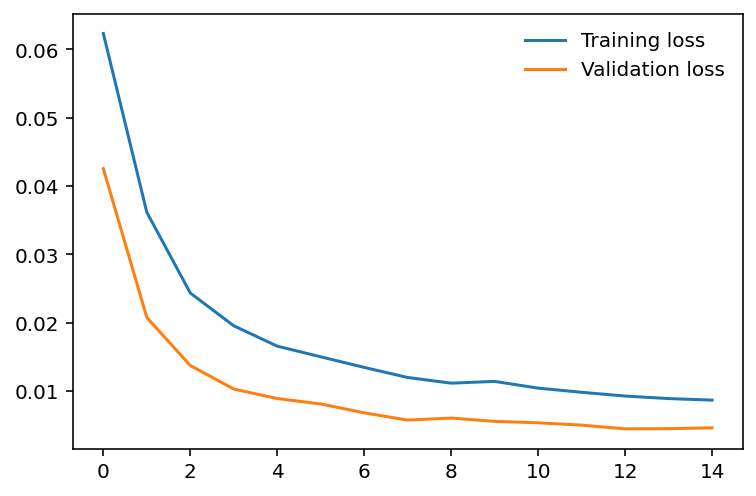

In [62]:
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

## Save and restore the model

In [9]:
checkpoint_file_path = "flwr_class_model.pth"

In [100]:
checkpoint = {'feature_model': 'densenet121',
              'hidden_size': hidden_size,
              'model_state': model.state_dict()}

torch.save(checkpoint, checkpoint_file_path)

In [10]:
checkpoint = None
checkpoint = torch.load(checkpoint_file_path)
model, optimizer, criterion = create_model_densenet121(hidden_size=checkpoint['hidden_size'])
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

## Test the model

In [37]:
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    shortest_side_size = 256
    crop_size = 224

    scale_factor = min(image.size) / shortest_side_size
    new_size = tuple([int(x / scale_factor) for x in image.size])
    image = image.resize(new_size)
    crop_width = (image.width - crop_size) // 2
    crop_height = (image.height - crop_size) // 2
    image = image.crop((crop_width, 
                        crop_height, 
                        image.width - crop_width, 
                        image.height - crop_height))

    np_image = np.array(image)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image / 255 - mean) / std
    np_image = np.transpose(np_image, (2, 0, 1))

    return np_image

In [38]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

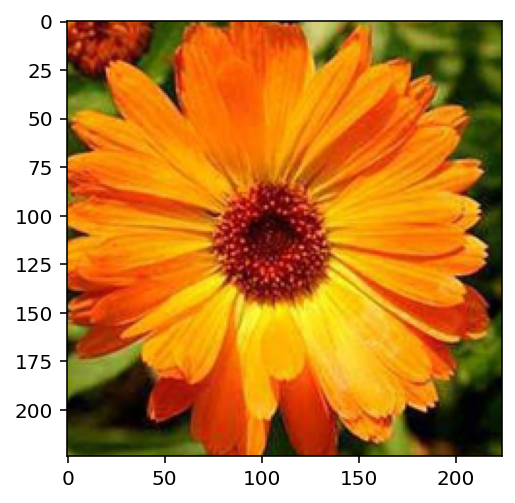

In [41]:
image_path = "flowers/test/5/image_05159.jpg"

with Image.open(image_path) as im:
    imshow(torch.from_numpy(process_image(im)))


## Another test tool

In [11]:
def view_image_prediction(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 224, 224).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(102))
    ax2.set_yticklabels(np.arange(102))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [12]:
def imshow2(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #print(cat_to_name[str(preds[j].item() + 1)])
                ax.set_title('predicted: {}, actual: {}'.format(cat_to_name[str(preds[j].item() + 1)],
                                                                cat_to_name[str(labels[j].item() + 1)]))
                imshow2(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

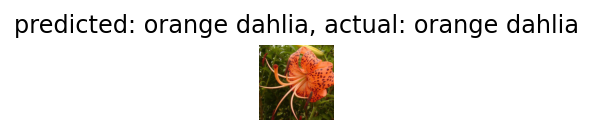

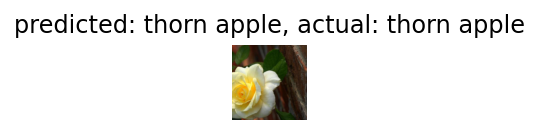

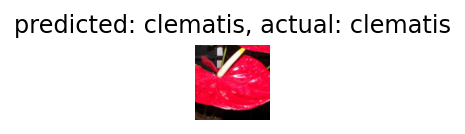

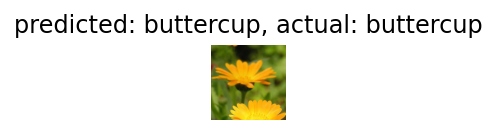

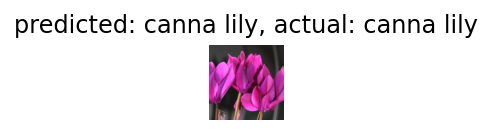

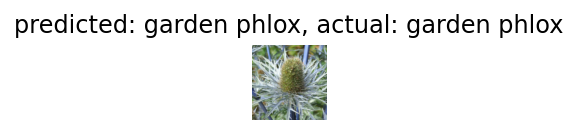

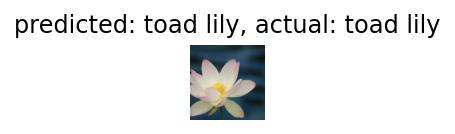

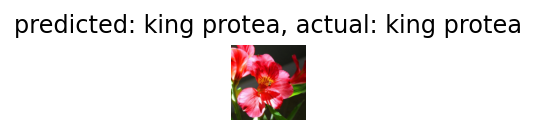

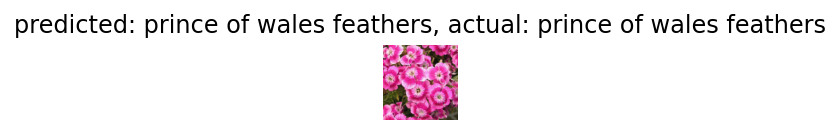

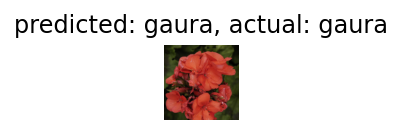

In [14]:
model.to(device)
visualize_model(model, testing_dataloader, num_images=10)